In [ ]:
#Importing all the required dependencies and required libraries
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import words
import numpy as np
import networkx as nx
from collections import Counter
import re

nltk.download('punkt')
df = pd.read_csv('/content/drive/MyDrive/inc_hack/patient_notes.csv')
df.columns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Index(['pn_num', 'case_num', 'pn_history'], dtype='object')

In [ ]:
#Displaying the columns in the database
df.keys()

Index(['pn_num', 'case_num', 'pn_history'], dtype='object')

In [ ]:
#Displaying the top 5 elements
df.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [ ]:
#Tokenization of the sentences using nltk
sentences = []
for s in df['pn_history']:
  sentences.append(sent_tokenize(s))
sentences = [y for x in sentences for y in x]
sentences[:20]

['17-year-old male, has come to the student health clinic complaining of heart pounding.',
 "Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like his heart is jumping out of his chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had MI recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std",
 '17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning.',
 'One time durign a baskeball game two days ago light headedness, pressure in the chest, catching breath, but no fainting.',
 'During teh episo

In [ ]:
#Making a word embeddings list to compare with
#Involves brute forcing 

word_embeddings = {}

glove_path = '/content/drive/MyDrive/inc_hack/glove.6B.100d.txt'
file = open(glove_path, encoding='utf-8')
for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
file.close()
len(word_embeddings)

6118

In [ ]:
#CLeaning the data using regex and pandas DF, Ignoring anything other than the letters from A-Z and a-z in strings
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
#Making the sentences lowercase for faster model detection
clean_sentences = [s.lower() for s in clean_sentences]

In [ ]:
#one time download nltk library for stopword removal
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Selecting the stopwords language
stop_words = stopwords.words('english')

In [ ]:
#Removing the stopwords from the cleaned sentences
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [ ]:
#Vectorization of sentences for feeding into models for model validation
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)
print(len(sentences))

423184


In [ ]:
#Selecting only first 1000 as the computational power increases exponentially with the number of cases, we tried to use 4000 and it computed in 46:07 minutes
sentences = sentences[0:1000]
print(len(sentences))
sim_mat = np.zeros([len(sentences), len(sentences)])

1000


In [ ]:
#Importing cosine similarity algorithm from scikit learn's library
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#implementing basic Cosine Similarity between the vectors which we got from the sentences
for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [ ]:
#Using PageRank algorithm for ranking of sentences as this method uses weights, similarity, frequency and occurance to decide importance of sentences words
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)


In [ ]:
#printing the first 5 Sentences to check, and as we have explained the summaries are more or less the exact as what we had given inputs, so this model was not used.
for i in range(5):
  print(ranked_sentences[i][1])

ROS: negative for chest pressure, chest pain, SOB, edema, palpitations, dizziness, headaches, lightheadedness, sweating, appetite or weight changes
PMH, PSH: none
Meds: none prescribed
NKDA
FH: mother has a "thyroid problem" and father has a "heart condition"
SH: takes Adderall illicitly a few times a week since starting college; smoked marijuana once; no tobacco; drinks 3-4 beers on weekends; plays basketball and runs regularly for exercise
Patient denies fever, night sweats, chills, abdominal pain, urinary/bowel habits changes, weight/appetite changes
PMH:unremarakble
PSH:Unremrakbale
Meds:Adarol to help with studies (started in the beginning of high school), last intake 3-4 days ago
SH:lives with roomate, smokes pot, non smoker, , drinks 3-4 beers on the weekend
FH:pateranl MI last year, maternal thyroid disease
Sexual: active with 1 girlfriend, heterosexual
No diaphoresis, no vomiting, no tremor, no loss of consciousness
No fever, no nausea or vomiting or diarrhea
No rash, no chang

In [ ]:
# ##################################

# GPT-2 MODEL FOR TEXT SUMMARIZATION 

# ##################################

#Importing the necessary libraries and modules
import torch
from summarizer import Summarizer,TransformerSummarizer
#An example of sentences which we will be using, the 'body' variable contains the cleaned_sentence[1] string and we will use it to demonstrate the GPT2_model
body = '''year old male has come to the student health clinic complaining of heart pounding mr cleveland s mother has given verbal consent for a history physical examination and treatment began months ago sudden intermittent for days lasting min  worsening non allev aggrav associated with dispnea on exersion and rest stressed out about school reports fe feels like his heart is jumping out of his chest ros denies chest pain dyaphoresis wt loss chills fever nausea vomiting pedal edeam pmh non meds aderol from a friend  nkda fh father had mi recently mother has thyroid dz sh non smoker mariguana '''
#Fitting the model for sample working as we didnt have enough time to fit the whole dataframe
GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")
#Joining the output of the model to make meaningful sentences
full = ''.join(GPT2_model(body, min_length=50))
#Printing
print(full)



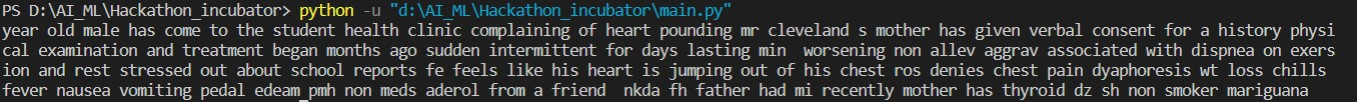